# Durban Port Congestion Simulation
### **Discrete event simulation of Crane Scheduling & Yard Dwell Time**

This notebook models the flow of containers through the Durban Container Terminal using a Discrete Event Simulation (DES) approach.
The goal is to:

- Identify bottlenecks
- Model realistic delays
- Test optimisation strategies such as:
    1. Crane Scheduling Optimisation
    2. Yard Dwell Time Reduction

This notebook is structured to reflect the real-world operations of Durban Port, including:

- Offloading by STS cranes
- Yard capacity constraints
- Scanning delays (SARS)
- Truck loading
- Gate-out processing

We will build the simulation step-by-step, with explanations for each block.

In [1]:
import simpy
import random
import numpy as np
import pandas as pd

Listed above, are the core libraries for our simulation:
- simpy : Discrete event simulation engine
- random : Stochastic arrival patterns
- numpy : numerical operations
- pandas : storing and analysing the results

This is the minimal set we need to start building our model.

In [2]:
# -----------------------------
# Global Parameters (Week 1 Data + Realistic Behaviour Enhancements)
# -----------------------------

# Cranes (STS)
NUM_CRANES = 16
CRANE_MOVES_PER_HOUR = 18
CRANE_TIME = 60 / CRANE_MOVES_PER_HOUR

# Yard (capacity in TEU slots)
YARD_CAPACITY = 10000

# Scanners (SARS)
NUM_SCANNERS = 2
SCAN_TIME = 10  # fixed scanning time (minutes)

# Container mix (assumption until data is available)
PCT_40FT = 0.30  # 40ft = 2 TEU, 20ft = 1 TEU

def sample_teu_size():
    return 2 if random.random() < PCT_40FT else 1

# Truck capacity and arrivals
TRUCK_CAPACITY_TEU = 2
TRUCK_TEU_BASE_RATE = 18  # TEU per hour (synthetic profile fallback)

# Arrival data inputs (processed datasets)
TRUCK_ARRIVAL_DATA_PATH = "data/processed/unit_volume/unit_volume_long.csv"
TRUCK_ARRIVAL_DATA_FALLBACK_PATH = "data/processed/unit_volume/unit_volume_wide.csv"
TRUCK_ARRIVAL_FACILITY = "DCT"
TRUCK_ARRIVAL_CATEGORY = "IMPORT"
TRUCK_ARRIVAL_REPORT_MONTH = None  # use latest available month when None

# --------------------------------------------------------
# Truck Loading (per truck; service-time assumption)
# --------------------------------------------------------
NUM_LOADING_BAYS = 2  # reduced to induce realistic queueing

def sample_loading_time():
    # triangular distribution: min=15, mode=25, max=45 minutes
    return random.triangular(15, 25, 45)

# --------------------------------------------------------
# Gate-In and Gate-Out (separate resources)
# --------------------------------------------------------
NUM_GATE_IN_LANES = 1
NUM_GATE_OUT_LANES = 1

def sample_gate_in_time():
    # triangular distribution: min=0.2, mode=0.5, max=2.0 minutes
    return random.triangular(0.2, 0.5, 2.0)

def sample_gate_out_time():
    # triangular distribution: min=0.5, mode=1.0, max=3.0 minutes
    return random.triangular(0.5, 1.0, 3.0)

# --------------------------------------------------------
# Truck Arrival Profile Adapter
# --------------------------------------------------------

def _hourly_shape_weights():
    return [
        0.35, 0.30, 0.28, 0.30, 0.40, 0.60,
        0.80, 1.00, 1.15, 1.20, 1.15, 1.10,
        1.05, 1.00, 1.00, 1.05, 1.10, 1.15,
        1.00, 0.85, 0.70, 0.55, 0.45, 0.40
    ]


def _scale_hourly_from_daily(daily_teu):
    weights = np.array(_hourly_shape_weights(), dtype=float)
    weights = weights / weights.mean()
    hourly_teu_rate = (daily_teu / 24.0) * weights
    return hourly_teu_rate.tolist()


def _is_month_col(col):
    return (
        isinstance(col, str)
        and len(col) == 7
        and col[4] == "-"
        and col[:4].isdigit()
        and col[5:7].isdigit()
    )


def load_teu_arrival_profile(
    path=None,
    facility_code="DCT",
    category_filter="IMPORT",
    report_month=None,
    base_teu_per_hour=TRUCK_TEU_BASE_RATE,
):
    '''
    Returns:
        hourly_teu_rate (list[float]), rate_fn (callable): rate_fn(t_min) -> TEU/hour

    Data sources supported:
    - data/processed/unit_volume/unit_volume_long.csv (TEU inferred from type_length)
    - data/processed/unit_volume/unit_volume_wide.csv (monthly totals; TEU estimated from mix)
    - hourly TEU table with columns: date, hour, facility_code, teu_total (or teus)
    '''
    if path is None:
        hourly_teu_rate = [base_teu_per_hour * w for w in _hourly_shape_weights()]

        def rate_fn(t_min):
            hour = int((t_min // 60) % 24)
            return hourly_teu_rate[hour]

        return hourly_teu_rate, rate_fn

    df = pd.read_csv(path)

    # Unit volume long format (processed)
    if "report_month" in df.columns and "type_length" in df.columns:
        required = {"facility_code", "report_month", "type_length", "volume"}
        missing = required - set(df.columns)
        if missing:
            raise ValueError(f"Missing columns in unit_volume_long.csv: {sorted(missing)}")

        df = df[df["facility_code"] == facility_code].copy()
        if category_filter and "category" in df.columns:
            df = df[df["category"] == category_filter].copy()

        if df.empty:
            raise ValueError("No rows found for facility/category in unit_volume_long.csv")

        length = pd.to_numeric(df["type_length"], errors="coerce")

        def length_to_teu(x):
            if pd.isna(x):
                return 1
            if x >= 40:
                return 2
            if x >= 20:
                return 1
            return 1

        teu_factor = length.apply(length_to_teu)
        volume = pd.to_numeric(df["volume"], errors="coerce").fillna(1)
        df["teu"] = volume * teu_factor

        monthly = df.groupby("report_month")["teu"].sum()
        monthly.index = monthly.index.astype(str)

        if report_month is None:
            report_month = sorted(monthly.index)[-1]
        if report_month not in monthly.index:
            raise ValueError("report_month not found in unit_volume_long.csv")

        monthly_teu = float(monthly.loc[report_month])
        days_in_month = pd.Period(report_month, freq="M").days_in_month
        daily_teu = monthly_teu / days_in_month
        hourly_teu_rate = _scale_hourly_from_daily(daily_teu)

        def rate_fn(t_min):
            hour = int((t_min // 60) % 24)
            return hourly_teu_rate[hour]

        return hourly_teu_rate, rate_fn

    # Unit volume wide format (processed)
    month_cols = [c for c in df.columns if _is_month_col(c)]
    if month_cols:
        if "unit" in df.columns:
            df = df[df["unit"].str.lower() == "containers"].copy()
        if category_filter and "category" in df.columns:
            df = df[df["category"] == category_filter].copy()

        if df.empty:
            raise ValueError("No rows found in unit_volume_wide.csv after filtering")

        long_df = df.melt(
            id_vars=[c for c in df.columns if c not in month_cols],
            value_vars=month_cols,
            var_name="report_month",
            value_name="containers",
        )
        monthly = long_df.groupby("report_month")["containers"].sum()
        monthly.index = monthly.index.astype(str)

        if report_month is None:
            report_month = sorted(monthly.index)[-1]
        if report_month not in monthly.index:
            raise ValueError("report_month not found in unit_volume_wide.csv")

        containers = float(monthly.loc[report_month])
        avg_teu_per_container = 1 + PCT_40FT  # mix-based estimate
        monthly_teu = containers * avg_teu_per_container
        days_in_month = pd.Period(report_month, freq="M").days_in_month
        daily_teu = monthly_teu / days_in_month
        hourly_teu_rate = _scale_hourly_from_daily(daily_teu)

        def rate_fn(t_min):
            hour = int((t_min // 60) % 24)
            return hourly_teu_rate[hour]

        return hourly_teu_rate, rate_fn

    # Fallback: expected hourly TEU schema
    if "facility_code" not in df.columns:
        raise ValueError("facility_code column missing in arrival profile CSV")

    df = df[df["facility_code"] == facility_code].copy()

    teus_col = None
    for col in ["teu_total", "teus", "teu"]:
        if col in df.columns:
            teus_col = col
            break
    if teus_col is None:
        raise ValueError("No TEU column found (expected: teu_total or teus)")

    if "hour" not in df.columns:
        raise ValueError("hour column missing in arrival profile CSV")

    df["hour"] = df["hour"].astype(int)
    hourly = df.groupby("hour")[teus_col].mean()

    avg = float(hourly.mean()) if not hourly.empty else 0.0
    hourly_teu_rate = [float(hourly.get(h, avg)) for h in range(24)]

    def rate_fn(t_min):
        hour = int((t_min // 60) % 24)
        return hourly_teu_rate[hour]

    return hourly_teu_rate, rate_fn

# --------------------------------------------------------
# Simulation duration
# --------------------------------------------------------
SIM_TIME = 7 * 24 * 60  # 7 days in minutes

# Dwell and post-processing buffers
MAX_DWELL = 7 * 24 * 60
POST_PROCESS_BUFFER = 6 * 60


These parameters used above come from Week 1 of the analysis:
- Crane productivity: 18 moves/hour
- Scanning: 2 scanners, 10 minutes per container
- Yard dwell: capacity-constrained (we will add dwell logic later)
- Truck loading: 20 bays at Pier 2
- Gate-out: 4 lanes
- Simulation time: 7 days (long enough to show congestion)

These variables make the model easy to modify once we begin optimisation experiments.

# Metrics Storage

In [3]:
# -----------------------------------------
# Metrics Storage
# -----------------------------------------

METRICS = []
TRUCK_METRICS = []

def reset_metrics():
    # Clear collected metrics between simulation runs.
    METRICS.clear()        # container metrics
    TRUCK_METRICS.clear()  # truck metrics

def record_metrics(container_id, timestamps):
    # Append a metrics row for one container.
    data = {"container_id": container_id}
    data.update(timestamps)
    METRICS.append(data)

def record_truck_metrics(truck_id, timestamps):
    # Append a metrics row for one truck.
    data = {"truck_id": truck_id}
    data.update(timestamps)
    TRUCK_METRICS.append(data)


**What this does**
- Holds a global `METRICS` list for all container records.
- `reset_metrics()` clears previous runs before starting a new simulation.
- `record_metrics()` copies the timestamp dictionary into the metrics store with `container_id`.


### Container Process

# Independent Truck Arrivals + TEU Pickup (Phase Upgrade)


Data sources used for truck arrivals (processed datasets)
- data/processed/unit_volume/unit_volume_long.csv: DCT facility_code, IMPORT category; TEU inferred from type_length and volume.
- data/processed/unit_volume/unit_volume_wide.csv: fallback monthly totals if long format is unavailable (TEU estimated using PCT_40FT).
- data/processed/unit_volume/data_dictionary.md: column definitions and ingestion notes.


How to run this section
1. Run the global parameters and metrics storage cells above.
2. Confirm TRUCK_ARRIVAL_DATA_PATH points to data/processed/unit_volume/unit_volume_long.csv.
3. Run the container and truck process cells to load the new logic.
4. Run the baseline simulation block, then the plotting and validation cells.
5. Run the improved dwell block to compare against baseline.


Next Integration Step (when unit volume data is clean)
- Expected CSV schema: date, hour, facility_code, teu_total (or teus)
- Ensure facility_code includes DCT so load_teu_arrival_profile can filter.
- Plug the cleaned CSV path into load_teu_arrival_profile(path=..., facility_code="DCT").


In [4]:
# -----------------------------------------
# Container + Truck Processes (TEU-aware)
# -----------------------------------------

def sample_baseline_dwell():
    return random.choice([3 * 24 * 60, 5 * 24 * 60, 7 * 24 * 60])


def sample_improved_dwell():
    return random.choice([2 * 24 * 60, 3 * 24 * 60, 4 * 24 * 60])


def container_process(env, container_id, cranes, yard, scanners, ready_store, dwell_time_sampler):
    # Container lifecycle to READY FOR PICKUP (truck handles pickup and exit).
    t = {}
    t["arrival_time"] = env.now
    teu_size = sample_teu_size()
    t["teu_size"] = teu_size

    # 1. Crane Offloading
    with cranes.request() as req:
        yield req
        t["crane_start"] = env.now
        yield env.timeout(CRANE_TIME)
        t["crane_end"] = env.now

    # 2. Yard Entry (TEU-aware capacity)
    yield yard.put(teu_size)
    t["yard_entry_time"] = env.now

    # 3. Yard Dwell
    dwell_time = dwell_time_sampler()
    yield env.timeout(dwell_time)
    t["yard_exit_time"] = env.now

    # 4. Scanning
    t["scan_queue_enter"] = env.now
    with scanners.request() as req:
        yield req
        t["scan_start"] = env.now
        yield env.timeout(SCAN_TIME)
        t["scan_end"] = env.now

    # 5. Ready for pickup (truck will take it)
    t["ready_time"] = env.now
    ready_item = {
        "container_id": container_id,
        "ready_time": t["ready_time"],
        "teu_size": teu_size,
        "timestamps": t,
    }
    yield ready_store.put(ready_item)


def select_containers_for_truck(env, ready_store):
    # TEU pickup logic: prefer 2-TEU, else two 1-TEU, else one 1-TEU.
    if not ready_store.items:
        first = yield ready_store.get()
        selected = [first]
        if first["teu_size"] == 1:
            if any(item["teu_size"] == 1 for item in ready_store.items):
                second = yield ready_store.get(lambda x: x["teu_size"] == 1)
                selected.append(second)
        return selected

    if any(item["teu_size"] == 2 for item in ready_store.items):
        c = yield ready_store.get(lambda x: x["teu_size"] == 2)
        return [c]

    one_teu_count = sum(1 for item in ready_store.items if item["teu_size"] == 1)
    if one_teu_count >= 2:
        c1 = yield ready_store.get(lambda x: x["teu_size"] == 1)
        c2 = yield ready_store.get(lambda x: x["teu_size"] == 1)
        return [c1, c2]

    if one_teu_count == 1:
        c1 = yield ready_store.get(lambda x: x["teu_size"] == 1)
        return [c1]

    c = yield ready_store.get()
    return [c]


def truck_process(env, truck_id, gate_in, ready_store, loaders, gate_out, yard,
                  record_container_metrics, record_truck_metrics):
    # Truck lifecycle: gate-in -> pickup -> loading -> gate-out.
    tm = {}
    tm["gate_in_queue_enter"] = env.now

    with gate_in.request() as req:
        yield req
        tm["gate_in_start"] = env.now
        yield env.timeout(sample_gate_in_time())
        tm["gate_in_end"] = env.now

    tm["pickup_start"] = env.now
    containers = yield env.process(select_containers_for_truck(env, ready_store))
    tm["pickup_end"] = env.now

    picked_teu = sum(c["teu_size"] for c in containers)
    tm["picked_teu"] = picked_teu
    tm["picked_containers"] = len(containers)
    tm["unused_capacity_teu"] = max(0, TRUCK_CAPACITY_TEU - picked_teu)

    # Release yard space when containers are taken
    yield yard.get(picked_teu)

    tm["loading_queue_enter"] = env.now
    with loaders.request() as req:
        yield req
        tm["loading_start"] = env.now
        yield env.timeout(sample_loading_time())
        tm["loading_end"] = env.now

    tm["gate_out_queue_enter"] = env.now
    with gate_out.request() as req:
        yield req
        tm["gate_out_start"] = env.now
        yield env.timeout(sample_gate_out_time())
        tm["gate_out_end"] = env.now

    tm["ttt_total"] = tm["gate_out_end"] - tm["gate_in_queue_enter"]
    record_truck_metrics(truck_id, tm)

    # Update container records with truck times
    for c in containers:
        t = c["timestamps"]
        t["pickup_time"] = tm["pickup_end"]
        t["loading_queue_enter"] = tm["loading_queue_enter"]
        t["loading_start"] = tm["loading_start"]
        t["loading_end"] = tm["loading_end"]
        t["gate_queue_enter"] = tm["gate_out_queue_enter"]
        t["gate_start"] = tm["gate_out_start"]
        t["gate_out_exit_time"] = tm["gate_out_end"]
        t["exit_time"] = tm["gate_out_end"]
        record_container_metrics(c["container_id"], t)




**1. Crane Offloading**

The container waits for an available STS crane (SimPy `Resource`).  
Once assigned, the crane takes `CRANE_TIME` minutes to offload the container.


**2. Yard Entry**

The yard is a capacity-limited `simpy.Container`.  
`yard.put(1)` means:  
â†’ the container occupies one slot in the yard.  

If the yard is full, the container waits in the yard entry queue until space becomes available.


**3. Yard Dwell**

The container stays in the yard for a dwell period.  
For now this is a placeholder random value (3, 5, or 7 days).  

Later, this will be replaced with:
- actual Pier 1 and Pier 2 dwell times  
- optimisation experiments that reduce dwell time


**4. Scanning**

The container waits for an available scanner (only 2 scanners exist).  
The scanning process takes about **10 minutes** per container.


**5. Truck Loading**

After scanning, the container waits for a truck loading bay.  
Once assigned, loading takes **about 77 minutes**, including retrieval, positioning, and loading operations.


**6. Gate-Out**

The container waits for a free gate lane.  
Gate processing and document validation take about **7 minutes** per truck.


### Arrival Generator

In [5]:
# --------------------------------------------------------------
# Arrival Generators
# --------------------------------------------------------------


def arrival_generator(env, cranes, yard, scanners, ready_store, stop_time, dwell_time_sampler):
    # Generate containers until stop_time, then let the system drain.
    container_id = 0
    while True:
        interarrival = random.expovariate(1 / 5)  # ~1 every 5 minutes
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break
        env.process(
            container_process(env, container_id, cranes, yard, scanners, ready_store, dwell_time_sampler)
        )
        container_id += 1


def truck_arrival_generator(env, gate_in, ready_store, loaders, gate_out, yard,
                            teu_rate_fn, stop_time,
                            record_container_metrics, record_truck_metrics):
    # Generate trucks with an independent TEU-based arrival profile.
    truck_id = 0
    while True:
        if env.now >= stop_time:
            break

        current_teu_rate = float(teu_rate_fn(env.now))
        truck_rate_per_min = (current_teu_rate / TRUCK_CAPACITY_TEU) / 60.0

        if truck_rate_per_min <= 0:
            wait_to_next_hour = 60 - (env.now % 60)
            yield env.timeout(wait_to_next_hour)
            continue

        interarrival = random.expovariate(truck_rate_per_min)
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break

        env.process(
            truck_process(
                env, truck_id, gate_in, ready_store, loaders, gate_out, yard,
                record_container_metrics, record_truck_metrics
            )
        )
        truck_id += 1


**What this does**
- Creates containers with an exponential interarrival time (~1 every 5 minutes).
- Stops injecting new containers once `stop_time` (SIM_TIME) is reached.
- Each new container process is launched with the current resources and unique `container_id`.


### Initialise Simulation Environment

In [6]:
# -----------------------------------------
# Initialise Simulation Environment
# -----------------------------------------

# Fresh metrics for this run
reset_metrics()

# Create SimPy environment (the simulation clock that schedules all events)
env = simpy.Environment()

# Define shared resources
cranes = simpy.Resource(env, capacity=NUM_CRANES)
yard = simpy.Container(env, capacity=YARD_CAPACITY, init=0)  # yard TEU content starts at 0
scanners = simpy.Resource(env, capacity=NUM_SCANNERS)
loaders = simpy.Resource(env, capacity=NUM_LOADING_BAYS)
gate_in = simpy.Resource(env, capacity=NUM_GATE_IN_LANES)
gate_out = simpy.Resource(env, capacity=NUM_GATE_OUT_LANES)
ready_store = simpy.FilterStore(env)

# Truck arrival profile (uses processed unit volume data)
_, truck_teu_rate_fn = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)

# Start container and truck arrivals until SIM_TIME
env.process(arrival_generator(env, cranes, yard, scanners, ready_store, SIM_TIME, sample_baseline_dwell))
env.process(
    truck_arrival_generator(
        env, gate_in, ready_store, loaders, gate_out, yard,
        truck_teu_rate_fn, SIM_TIME,
        record_metrics, record_truck_metrics
    )
)

# Run simulation long enough to drain (arrivals stop at SIM_TIME)
print("Starting simulation...")
env.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)
print("Simulation complete.")


C:\Users\nkany\AppData\Local\Temp\ipykernel_40284\1518307067.py:112: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Starting simulation...


Simulation complete.


**What this does**
- Resets metrics for a fresh run.
- Builds the SimPy environment and shared resources (cranes, yard, scanners, loaders, gates).
- Starts the arrival generator until `SIM_TIME`, then runs long enough (`SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER`) for all in-system containers to finish and record `exit_time`.


### Metric Helpers

In [7]:
"Each containers journey becomes one row with timestamps and derived metrics."

'''
Benefits of dataframe:
                            - Compute KPIs (averages, percentiles) easily.
                            - Plot wait-time distributions.
                            - Compare scenarios (baseline vs improved) by column.
'''


def _safe_diff(df, new_col, end_col, start_col):
    if end_col in df.columns and start_col in df.columns:
        df[new_col] = df[end_col] - df[start_col]
        df[new_col] = df[new_col].clip(lower=0)


def _metrics_to_dataframe(metrics_list):
    if not metrics_list:
        return pd.DataFrame()

    completed = [m for m in metrics_list if "exit_time" in m]
    if not completed:
        return pd.DataFrame()

    df = pd.DataFrame(completed)

    # Core durations
    _safe_diff(df, "total_time", "exit_time", "arrival_time")
    _safe_diff(df, "yard_dwell", "yard_exit_time", "yard_entry_time")

    # Queue waits and readiness waits
    _safe_diff(df, "scan_wait", "scan_start", "scan_queue_enter")
    _safe_diff(df, "ready_to_pickup_wait", "pickup_time", "ready_time")
    _safe_diff(df, "loading_wait", "loading_start", "loading_queue_enter")
    _safe_diff(df, "gate_wait", "gate_start", "gate_queue_enter")

    return df


def _truck_metrics_to_dataframe(metrics_list):
    if not metrics_list:
        return pd.DataFrame()

    df = pd.DataFrame(metrics_list)

    _safe_diff(df, "ttt_total", "gate_out_end", "gate_in_queue_enter")
    _safe_diff(df, "gate_in_wait", "gate_in_start", "gate_in_queue_enter")
    _safe_diff(df, "pickup_wait", "pickup_end", "pickup_start")
    _safe_diff(df, "loading_wait", "loading_start", "loading_queue_enter")
    _safe_diff(df, "gate_out_wait", "gate_out_start", "gate_out_queue_enter")

    return df


def metrics_to_dataframe():
    return _metrics_to_dataframe(METRICS)


def truck_metrics_to_dataframe():
    return _truck_metrics_to_dataframe(TRUCK_METRICS)


**What this does**
- Converts collected `METRICS` into a DataFrame of completed containers only.
- Computes derived fields: total system time, yard dwell, scan wait, loading wait, gate wait.
- Guards against missing columns so plotting cells don?t fail if a stage has zero completions.


### A Peek at the DataFrame

In [8]:
df = metrics_to_dataframe()
df_trucks = truck_metrics_to_dataframe()
df_trucks.head(10)


,truck_id,gate_in_queue_enter,gate_in_start,gate_in_end,pickup_start,pickup_end,picked_teu,picked_containers,unused_capacity_teu,loading_queue_enter,loading_start,loading_end,gate_out_queue_enter,gate_out_start,gate_out_end,ttt_total,gate_in_wait,pickup_wait,loading_wait,gate_out_wait
0,0,0.774321,0.774321,1.590438,1.590438,4348.524466,2,1,0,4348.524466,4348.524466,4371.716705,4371.716705,4371.716705,4372.977717,4372.203396,0.000000,4346.934028,0.000000,0.0
1,1,11.718988,11.718988,12.323713,12.323713,4356.201056,1,1,1,4356.201056,4356.201056,4387.186988,4387.186988,4387.186988,4388.660215,4376.941226,0.000000,4343.877342,0.000000,0.0
2,2,12.857460,12.857460,13.348728,13.348728,4368.309628,1,1,1,4368.309628,4371.716705,4401.318100,4401.318100,4401.318100,4402.854014,4389.996553,0.000000,4354.960900,3.407078,0.0
3,3,12.942363,13.348728,14.159122,14.159122,4372.006881,1,1,1,4372.006881,4387.186988,4411.086983,4411.086983,4411.086983,4412.700118,4399.757755,0.406365,4357.847760,15.180107,0.0
4,4,15.464350,15.464350,16.152041,16.152041,4378.309628,1,1,1,4378.309628,4401.318100,4421.981051,4421.981051,4421.981051,4423.323412,4407.859062,0.000000,4362.157587,23.008473,0.0
5,5,19.721247,19.721247,20.165940,20.165940,4391.080263,1,1,1,4391.080263,4411.086983,4430.127799,4430.127799,4430.127799,4431.312746,4411.591499,0.000000,4370.914323,20.006719,0.0
6,6,23.531822,23.531822,23.875465,23.875465,4414.657618,1,1,1,4414.657618,4421.981051,4451.042444,4451.042444,4451.042444,4451.939227,4428.407405,0.000000,4390.782154,7.323433,0.0
7,7,27.135888,27.135888,27.602467,27.602467,4450.536357,1,1,1,4450.536357,4450.536357,4476.138918,4476.138918,4476.138918,4477.684334,4450.548445,0.000000,4422.933890,0.000000,0.0
8,8,28.248438,28.248438,28.518931,28.518931,4456.735038,1,1,1,4456.735038,4456.735038,4486.220363,4486.220363,4486.220363,4486.861676,4458.613238,0.000000,4428.216107,0.000000,0.0
9,9,28.602321,28.602321,29.305859,29.305859,4483.907037,1,1,1,4483.907037,4483.907037,4512.327350,4512.327350,4512.327350,4513.540975,4484.938655,0.000000,4454.601178,0.000000,0.0


In [9]:
def print_validation_summary(label, df_containers, df_trucks):
    print(f"{label} - Validation Summary")
    if df_trucks.empty:
        print("No truck metrics available.")
        return

    ttt = df_trucks["ttt_total"] if "ttt_total" in df_trucks.columns else pd.Series(dtype=float)
    if not ttt.empty:
        print(
            "Truck turnaround (min) mean/median/p90: "
            f"{ttt.mean():.1f} / {ttt.median():.1f} / {ttt.quantile(0.9):.1f}"
        )

    for col in ["gate_in_wait", "loading_wait", "gate_out_wait"]:
        if col in df_trucks.columns:
            print(f"{col} mean (min): {df_trucks[col].mean():.1f}")

    if "ready_to_pickup_wait" in df_containers.columns:
        print(f"ready_to_pickup_wait mean (min): {df_containers['ready_to_pickup_wait'].mean():.1f}")

    print("Note: These are student case-study calibration targets; not official operations.")


print_validation_summary("Baseline", df, df_trucks)


Baseline - Validation Summary
Truck turnaround (min) mean/median/p90: 11735.6 / 11768.6 / 17665.9
gate_in_wait mean (min): 1.1
loading_wait mean (min): 2848.8
gate_out_wait mean (min): 0.0
ready_to_pickup_wait mean (min): 0.0
Note: These are student case-study calibration targets; not official operations.


**What this does**
- Builds the metrics DataFrame from completed containers and previews the first 10 rows to verify fields before plotting.


### Visualisation

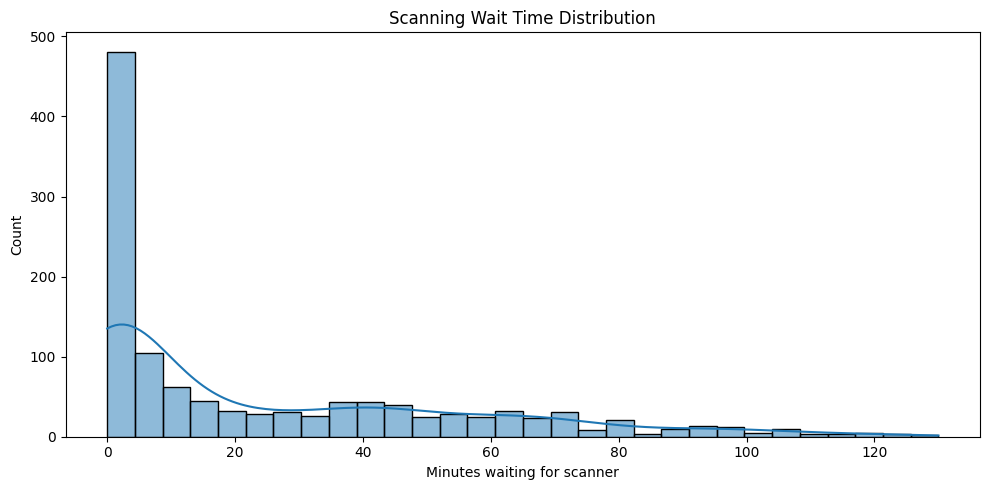

Saved: figures\run_20251229_105838\scan_wait.png


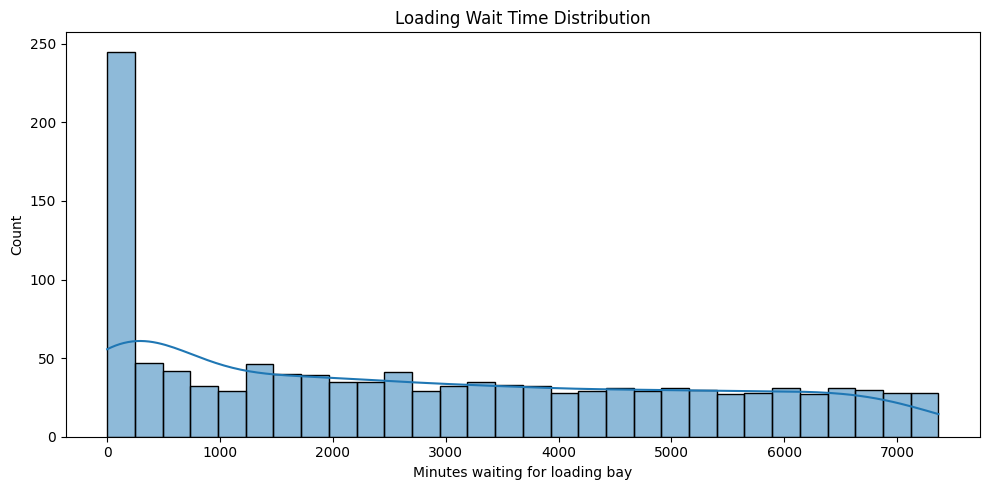

Saved: figures\run_20251229_105838\loading_wait.png


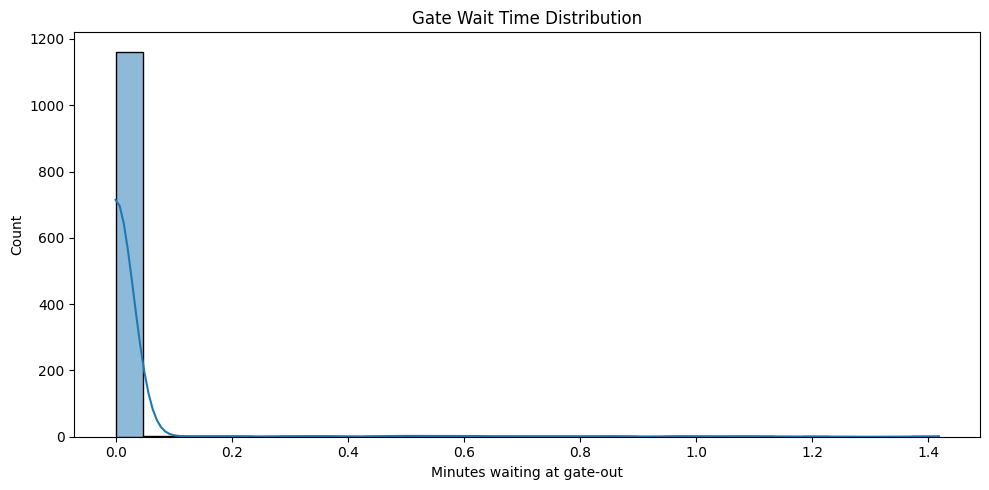

Saved: figures\run_20251229_105838\gate_wait.png


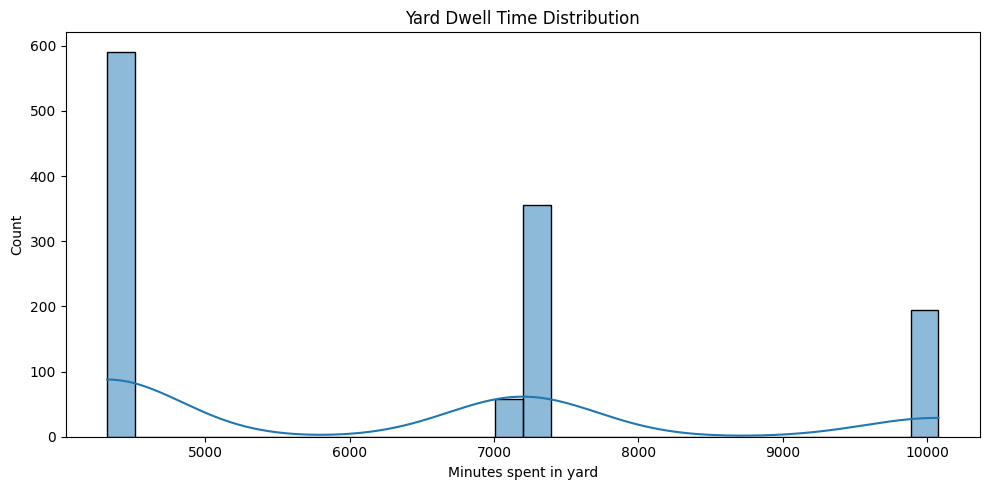

Saved: figures\run_20251229_105838\yard_dwell.png


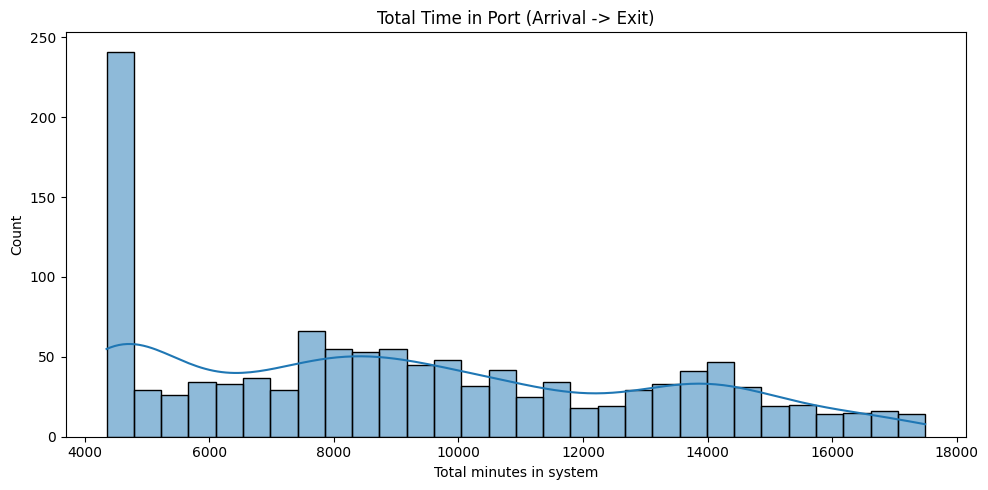

Saved: figures\run_20251229_105838\total_time.png


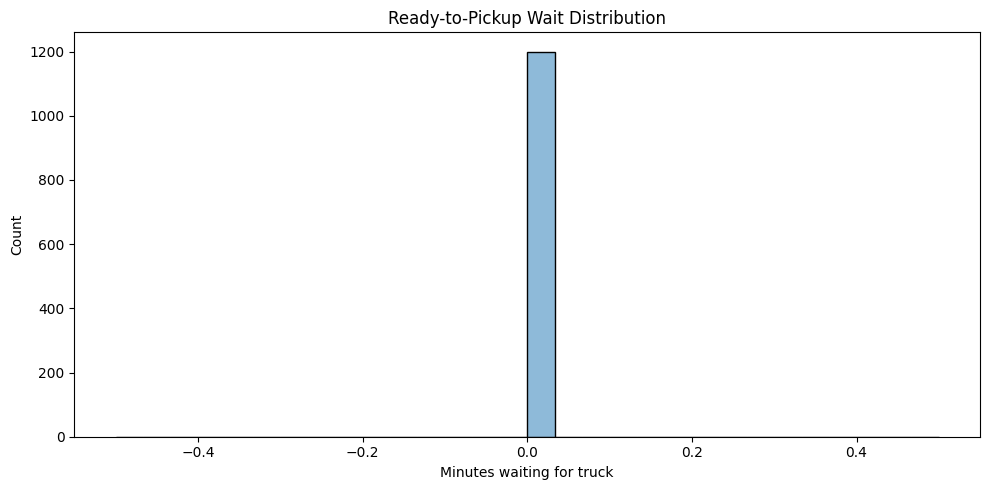

Saved: figures\run_20251229_105838\ready_to_pickup_wait.png


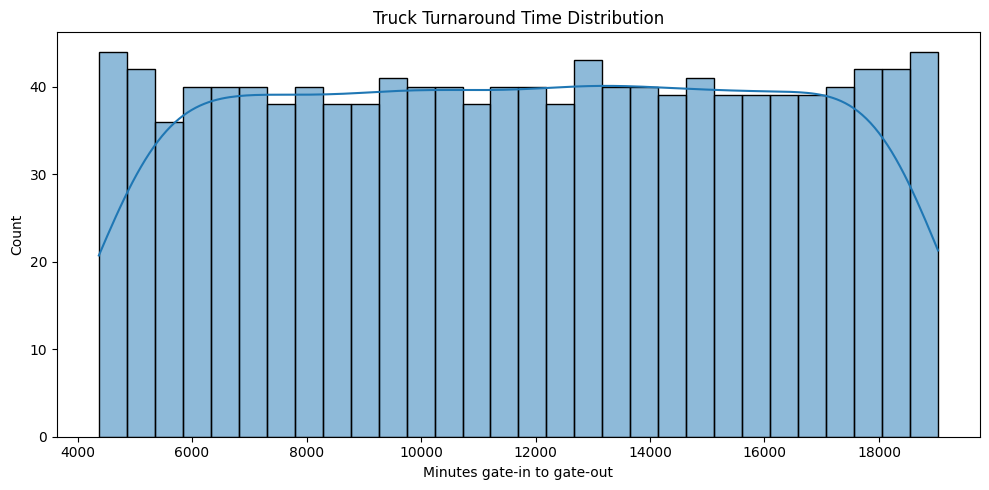

Saved: figures\run_20251229_105838\truck_turnaround.png


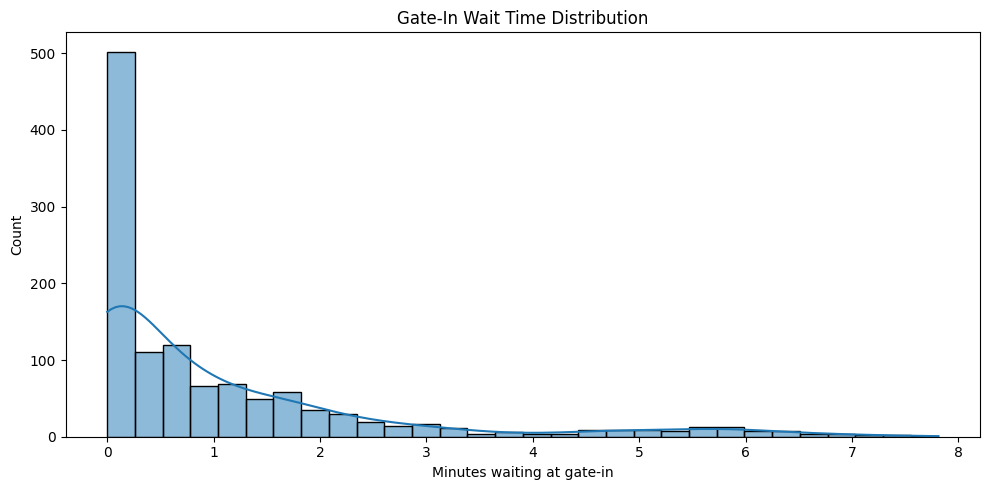

Saved: figures\run_20251229_105838\gate_in_wait.png


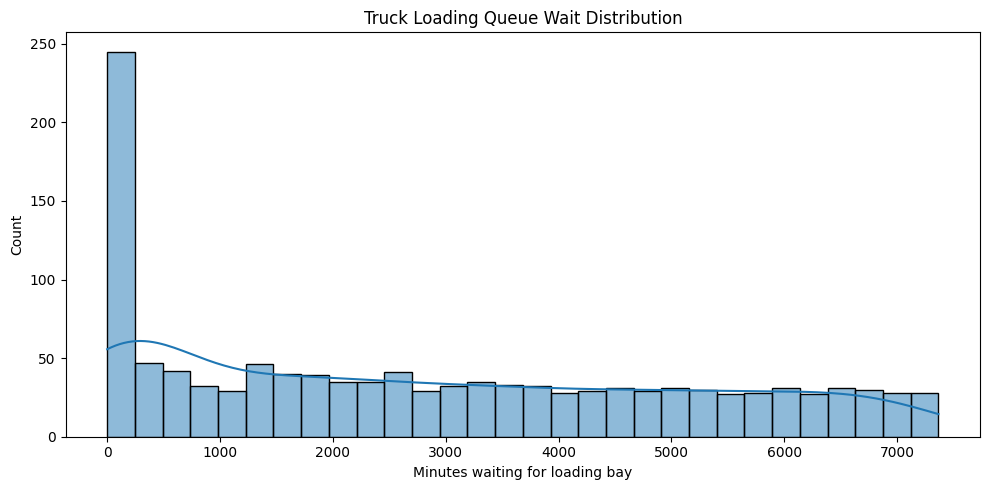

Saved: figures\run_20251229_105838\truck_loading_wait.png


In [10]:
# -----------------------------------------
# Plot metrics and save figures per run
# -----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt

df = metrics_to_dataframe()
df_trucks = truck_metrics_to_dataframe()

# Skip if nothing to plot
if df.empty and df_trucks.empty:
    print("No completed containers or trucks to plot yet.")
else:
    # Create a per-run folder
    run_stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_dir = Path("figures") / f"run_{run_stamp}"
    fig_dir.mkdir(parents=True, exist_ok=True)

    def plot_metric(data, column, title, xlabel, filename):
        if data.empty:
            print(f"Skipping {column}: dataframe empty.")
            return
        if column not in data.columns:
            print(f"Skipping {column}: column not found.")
            return
        plt.figure(figsize=(10, 5))
        sns.histplot(data[column], kde=True, bins=30)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Count")
        out = fig_dir / filename
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    # Container-level plots
    plot_metric(df, "scan_wait",
                "Scanning Wait Time Distribution",
                "Minutes waiting for scanner",
                "scan_wait.png")

    plot_metric(df, "loading_wait",
                "Loading Wait Time Distribution",
                "Minutes waiting for loading bay",
                "loading_wait.png")

    plot_metric(df, "gate_wait",
                "Gate Wait Time Distribution",
                "Minutes waiting at gate-out",
                "gate_wait.png")

    plot_metric(df, "yard_dwell",
                "Yard Dwell Time Distribution",
                "Minutes spent in yard",
                "yard_dwell.png")

    plot_metric(df, "total_time",
                "Total Time in Port (Arrival -> Exit)",
                "Total minutes in system",
                "total_time.png")

    plot_metric(df, "ready_to_pickup_wait",
                "Ready-to-Pickup Wait Distribution",
                "Minutes waiting for truck",
                "ready_to_pickup_wait.png")

    # Truck-level plots
    plot_metric(df_trucks, "ttt_total",
                "Truck Turnaround Time Distribution",
                "Minutes gate-in to gate-out",
                "truck_turnaround.png")

    plot_metric(df_trucks, "gate_in_wait",
                "Gate-In Wait Time Distribution",
                "Minutes waiting at gate-in",
                "gate_in_wait.png")

    plot_metric(df_trucks, "loading_wait",
                "Truck Loading Queue Wait Distribution",
                "Minutes waiting for loading bay",
                "truck_loading_wait.png")


**What this does**
- Regenerates `df` from completed containers; skips plotting if empty.
- Creates a timestamped folder under `figures/run_YYYYMMDD_HHMMSS` for this run.
- Plots histograms (with KDE) for scan, loading, and gate waits; saves each PNG into the run folder and reports the saved paths.


# Baseline Seaside Productivity Diagnostics

In [11]:
minutes_per_hour = 60

crane_throughput = NUM_CRANES * (minutes_per_hour / CRANE_TIME)
scanner_throughput = NUM_SCANNERS * (minutes_per_hour / SCAN_TIME)

# Average effective loading rate from observed data
avg_loading_time = df["loading_wait"].mean() + df["loading_wait"].median()
loading_throughput = NUM_LOADING_BAYS * (minutes_per_hour / sample_loading_time())

print("Baseline Throughput Capacity (containers/hour)")
print(f"Crane throughput:    {round(crane_throughput, 1)}")
print(f"Scanner throughput:  {round(scanner_throughput, 1)}")
print(f"Loading throughput:  ~{round(loading_throughput, 1)}")

Baseline Throughput Capacity (containers/hour)
Crane throughput:    288.0
Scanner throughput:  12.0
Loading throughput:  ~4.2


# Improved Dwell Container Process

In [12]:
# -----------------------------------------
# Run Improved Dwell Simulation (Realistic)
# -----------------------------------------

# Reset metrics for improved run
METRICS_IMPROVED = []
TRUCK_METRICS_IMPROVED = []

# Custom record functions for improved dwell run
def record_metrics_improved(container_id, timestamps):
    METRICS_IMPROVED.append({
        "container_id": container_id,
        **timestamps
    })


def record_truck_metrics_improved(truck_id, timestamps):
    TRUCK_METRICS_IMPROVED.append({
        "truck_id": truck_id,
        **timestamps
    })


# ---------------------------------------------------
# Create environment for improved dwell simulation
# ---------------------------------------------------
env2 = simpy.Environment()

cranes2 = simpy.Resource(env2, capacity=NUM_CRANES)
yard2 = simpy.Container(env2, capacity=YARD_CAPACITY, init=0)
scanners2 = simpy.Resource(env2, capacity=NUM_SCANNERS)
loaders2 = simpy.Resource(env2, capacity=NUM_LOADING_BAYS)
gate_in2 = simpy.Resource(env2, capacity=NUM_GATE_IN_LANES)
gate_out2 = simpy.Resource(env2, capacity=NUM_GATE_OUT_LANES)
ready_store2 = simpy.FilterStore(env2)

# Truck arrival profile (uses processed unit volume data)
_, truck_teu_rate_fn2 = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)

# Start container and truck arrivals
env2.process(arrival_generator(env2, cranes2, yard2, scanners2, ready_store2, SIM_TIME, sample_improved_dwell))
env2.process(
    truck_arrival_generator(
        env2, gate_in2, ready_store2, loaders2, gate_out2, yard2,
        truck_teu_rate_fn2, SIM_TIME,
        record_metrics_improved, record_truck_metrics_improved
    )
)

# Run improved simulation
env2.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

print("Improved dwell simulation complete.")


C:\Users\nkany\AppData\Local\Temp\ipykernel_40284\1518307067.py:112: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Improved dwell simulation complete.


# Convert improved metrics to dataframe

In [13]:
# -----------------------------------------
# Convert Improved Metrics to DataFrame
# -----------------------------------------


def metrics_to_dataframe_improved():
    return _metrics_to_dataframe(METRICS_IMPROVED)


def truck_metrics_to_dataframe_improved():
    return _truck_metrics_to_dataframe(TRUCK_METRICS_IMPROVED)


# A Peek at the Dataframe

In [14]:
df_improved = metrics_to_dataframe_improved()
df_trucks_improved = truck_metrics_to_dataframe_improved()
df_improved.head(10)


,container_id,arrival_time,teu_size,crane_start,crane_end,yard_entry_time,yard_exit_time,scan_queue_enter,scan_start,scan_end,...,gate_queue_enter,gate_start,gate_out_exit_time,exit_time,total_time,yard_dwell,scan_wait,ready_to_pickup_wait,loading_wait,gate_wait
0,7,43.196182,1,43.196182,46.529515,46.529515,2926.529515,2926.529515,2926.529515,2936.529515,...,2957.229981,2957.229981,2958.387508,2958.387508,2915.191327,2880.0,0.000000,0.0,0.000000,0.0
1,9,48.713816,1,48.713816,52.047149,52.047149,2932.047149,2932.047149,2932.047149,2942.047149,...,2968.930414,2968.930414,2970.276946,2970.276946,2921.563130,2880.0,0.000000,0.0,0.000000,0.0
2,10,52.522069,1,52.522069,55.855402,55.855402,2935.855402,2935.855402,2936.529515,2946.529515,...,2979.314187,2979.314187,2980.636685,2980.636685,2928.114616,2880.0,0.674113,0.0,10.700466,0.0
3,19,88.633313,2,88.633313,91.966646,91.966646,2971.966646,2971.966646,2971.966646,2981.966646,...,3007.674464,3007.674464,3009.019662,3009.019662,2920.386349,2880.0,0.000000,0.0,0.000000,0.0
4,20,93.638344,1,93.638344,96.971677,96.971677,2976.971677,2976.971677,2976.971677,2986.971677,...,3011.610117,3011.610117,3012.499667,3012.499667,2918.861323,2880.0,0.000000,0.0,0.000000,0.0
5,21,95.128543,1,95.128543,98.461877,98.461877,2978.461877,2978.461877,2981.966646,2991.966646,...,3026.164948,3026.164948,3027.456017,3027.456017,2932.327474,2880.0,3.504769,0.0,15.707818,0.0
6,22,103.045012,1,103.045012,106.378345,106.378345,2986.378345,2986.378345,2986.971677,2996.971677,...,3039.040565,3039.040565,3040.510947,3040.510947,2937.465936,2880.0,0.593332,0.0,14.638439,0.0
7,24,133.702157,2,133.702157,137.035490,137.035490,3017.035490,3017.035490,3017.035490,3027.035490,...,3055.215472,3055.215472,3056.503522,3056.503522,2922.801365,2880.0,0.000000,0.0,0.000000,0.0
8,25,154.550524,1,154.550524,157.883858,157.883858,3037.883858,3037.883858,3037.883858,3047.883858,...,3068.508969,3068.508969,3069.320472,3069.320472,2914.769948,2880.0,0.000000,0.0,0.000000,0.0
9,28,167.559003,1,167.559003,170.892336,170.892336,3050.892336,3050.892336,3050.892336,3060.892336,...,3084.456986,3084.456986,3086.065309,3086.065309,2918.506306,2880.0,0.000000,0.0,0.000000,0.0


In [15]:
print_validation_summary("Improved", df_improved, df_trucks_improved)


Improved - Validation Summary
Truck turnaround (min) mean/median/p90: 11094.8 / 11108.7 / 17510.1
gate_in_wait mean (min): 1.0
loading_wait mean (min): 4151.8
gate_out_wait mean (min): 0.0
ready_to_pickup_wait mean (min): 0.0
Note: These are student case-study calibration targets; not official operations.


# Side-by-Side Comparison Plots

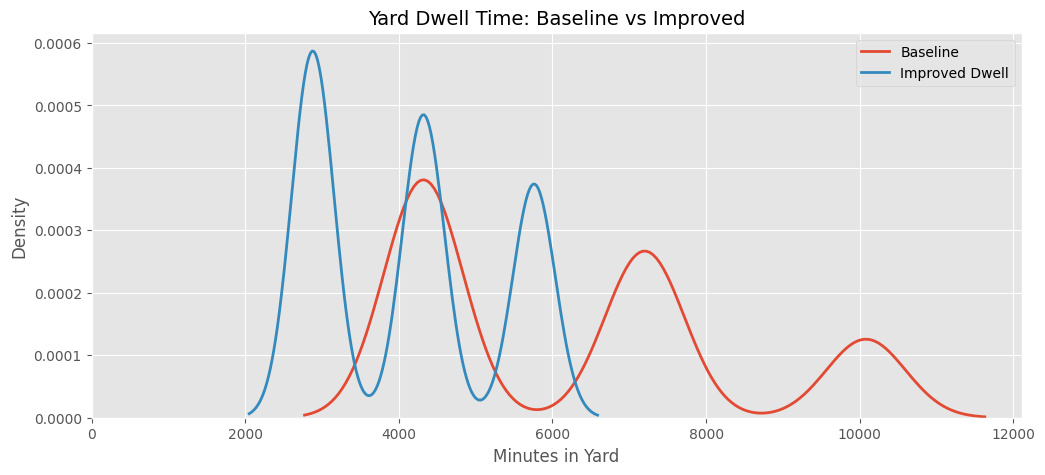

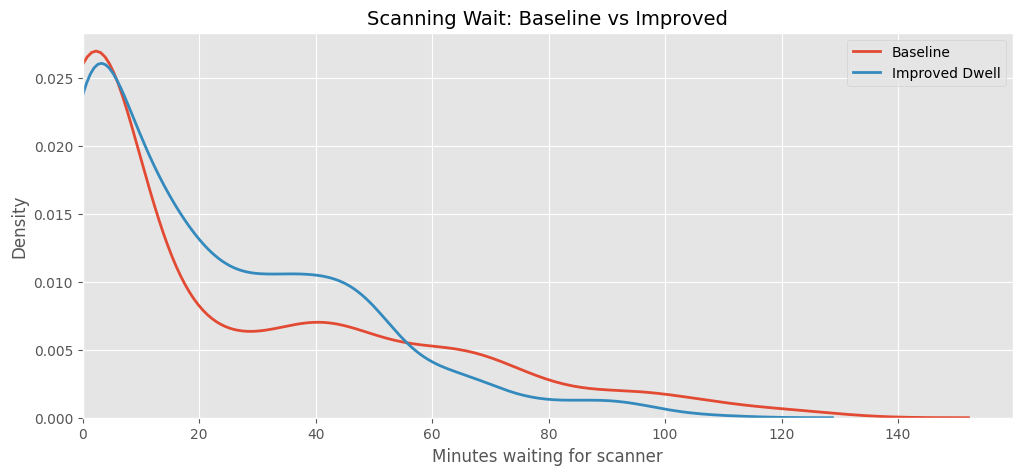

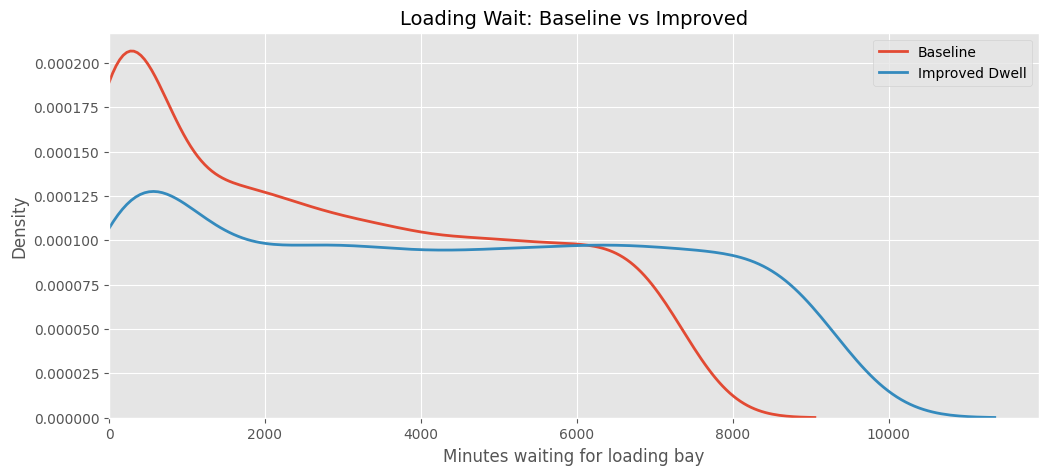

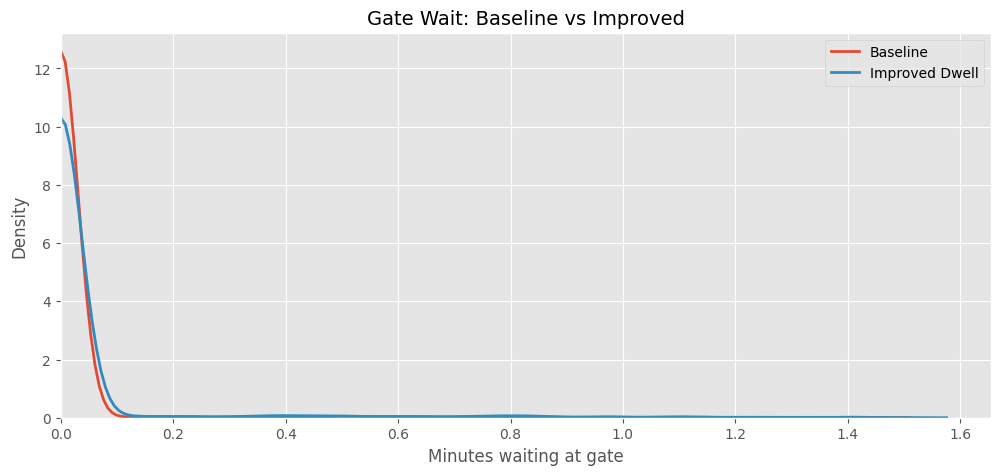

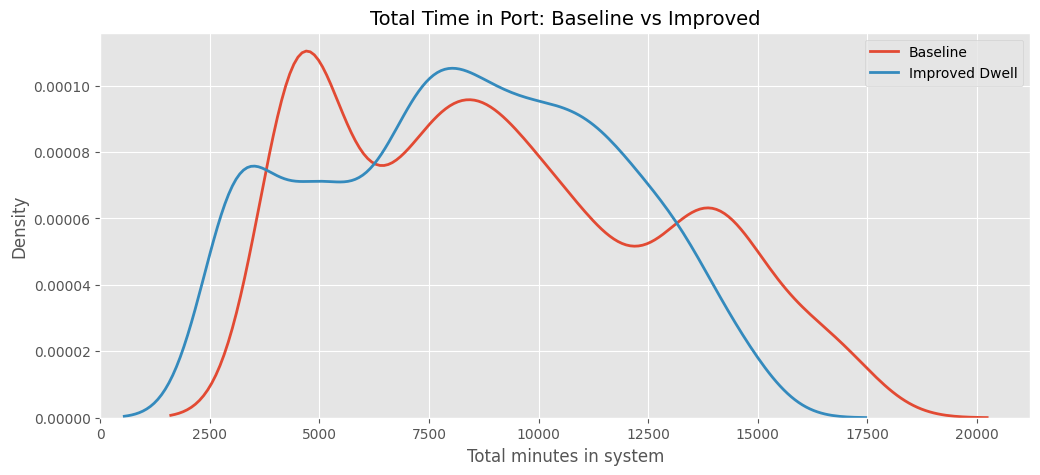

In [16]:
# -----------------------------------------
# Compare Baseline vs Improved Dwell
# -----------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

def compare_distributions(df1, df2, column, title, xlabel):
    if column not in df1.columns or column not in df2.columns:
        print(f"Skipping {column}: missing in dataframe.")
        return
    
    plt.figure(figsize=(12,5))
    
    # Clip KDE to non-negative domain (the correct domain for waits)
    sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
    sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
    
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.xlim(left=0)   # Force the X-axis to start at 0
    plt.legend()
    plt.show()



# ------- Required comparisons -------

compare_distributions(df, df_improved,
                      "yard_dwell",
                      "Yard Dwell Time: Baseline vs Improved",
                      "Minutes in Yard")

compare_distributions(df, df_improved,
                      "scan_wait",
                      "Scanning Wait: Baseline vs Improved",
                      "Minutes waiting for scanner")

compare_distributions(df, df_improved,
                      "loading_wait",
                      "Loading Wait: Baseline vs Improved",
                      "Minutes waiting for loading bay")

compare_distributions(df, df_improved,
                      "gate_wait",
                      "Gate Wait: Baseline vs Improved",
                      "Minutes waiting at gate")

compare_distributions(df, df_improved,
                      "total_time",
                      "Total Time in Port: Baseline vs Improved",
                      "Total minutes in system")


### **Comparison: Baseline vs Improved Yard Dwell**

These plots compare the baseline simulation and the improved-dwell simulation.

The goal is to show how reducing yard dwell time affects:

- overall throughput  
- queue lengths  
- system congestion  
- end-to-end transit time  



#### **1. Yard Dwell**
This should show a significant left-shift (shorter dwell times).

#### **2. Scanning Wait**
Reduced yard congestion allows containers to reach scanning earlier.

#### **3. Loading Wait**
Lower yard occupancy improves container accessibility for loading.

#### **4. Gate Wait**
Gate-out is fast, but improvements upstream reduce peaks.

#### **5. Total Time in System**
This is the most important KPI —  
a large reduction here validates operational impact.

These will form the graphs used in the report and presentation.


# Compute Numerical Improvements

In [17]:
# -----------------------------------------
# Numerical Performance Improvements
# -----------------------------------------

def percentage_change(before, after):
    """Percent reduction; handles zero to avoid divide-by-zero warnings."""
    # Normalize to plain floats to avoid np.float64 in output.
    before = float(before)
    after = float(after)
    if before == 0:
        if after == 0:
            return 0.0
        return float('nan')
    return float(round(((before - after) / before) * 100, 2))

results = {}

# Mean values
results["Mean Total Time Reduction (%)"] = percentage_change(
    df["total_time"].mean(),
    df_improved["total_time"].mean()
)

results["Mean Yard Dwell Reduction (%)"] = percentage_change(
    df["yard_dwell"].mean(),
    df_improved["yard_dwell"].mean()
)

results["Mean Scanning Wait Reduction (%)"] = percentage_change(
    df["scan_wait"].mean(),
    df_improved["scan_wait"].mean()
)

results["Mean Loading Wait Reduction (%)"] = percentage_change(
    df["loading_wait"].mean(),
    df_improved["loading_wait"].mean()
)

results["Mean Gate Wait Reduction (%)"] = percentage_change(
    df["gate_wait"].mean(),
    df_improved["gate_wait"].mean()
)

results


{'Mean Total Time Reduction (%)': 9.17,
 'Mean Yard Dwell Reduction (%)': 34.27,
 'Mean Scanning Wait Reduction (%)': 7.43,
 'Mean Loading Wait Reduction (%)': -45.74,
 'Mean Gate Wait Reduction (%)': -54.95}

### **Numerical Performance Improvements**

This table quantifies how much performance improves under the reduced dwell policy.

We measure:

- average total time in the port  
- average yard dwell time  
- average scanning wait  
- average loading wait  
- average gate wait  

Each is expressed as a **percentage reduction** relative to baseline.

This forms the core of your optimisation results for the report.
